In [2]:
%load_ext autoreload
%autoreload 2
%cd ..


c:\Users\troosma\Documents\Ylikool\6. semester\Bakatöö\bakatoo


In [2]:
%load_ext snakeviz


In [3]:
import sys
import os

import numpy as np
import random
import tensorflow as tf

from tensorflow import keras
from keras import layers

from matplotlib import pyplot as plt
import seaborn as sns

from scripts.CustomCallbacks import CustomLogger
import scripts.utils as utils
import scripts.Slopes as Slopes

utils.reset_seeds(0)


grid on pmst test
müra määr, tegelik (valemist) & empiriline (vahemikus)
optimaalne rmse andmetel

keskväärtusest saab mudeli_rmse_train ja _test 
dispersioonist saab lõigu keskmise variance **0.5 mse_hinnang

neid saab siis vahemikus 
1. ennustatud keskväärtus - tegelik
2. kaugel on ennustatud keskväärtus - (treening)andmepunktist 
3. kaugel on ennustatud keskväärtus - (test)andmepunktist 
4. kui suur ennustatud standardhälve
5. tegelik müra tase (müra gene valemist)
6. sample (vahemiku) variance 


iga treeningpunktil mõõdetud asi saab ka teha testpunktidel
1. tegelik müra (müratase, müramäär valemist)
2. ennustatud määramatus (müra määr)
3. kaugel on punkt - ennustus keksväärtus
4. fn (tegelik keskv) - ennustus keskv  
5. kaugel on punk - tegelik fn

bias-variance decomposition - kui MSEga vaadata siis tuleb kahe summaks kolmas
roheline hakkab kesketläbi klappima ennustadu määramatus läheb klappima empiirilise määramatusega (2.,3.)
2 peab alati > kui 1
1.+4. = 3. (treeningandmetel)

TODO: https://en.wikipedia.org/wiki/Bias%E2%80%93variance_tradeoff 
TODO: bias–variance decomposition
kuidas 2 käitub??

1 aleaotooriline
3-4 tegelikud vead
kuidas 2 aitab ennustada 3-4

6. punkt - tegelik (empiiriline müra)
7. kahte variance vaadata

In [4]:
def joonista_variance(m: tf.keras.Sequential, X_test, X_train, y_train=None, bpoint_fn=Slopes.breakpoint_finder, *, ground_truth=False, xlim=None, ylim=None, returnplt=False, no_variance=False):

    bpoints = bpoint_fn(m, X_test)

    _patterns = [bp[1] for bp in bpoints]
    bpoints = [bp[0] for bp in bpoints]

    start, end = xlim if xlim else (-1, 1)

    print(f"model contains {len(bpoints)} breaks")

    y_pred = m.predict(X_test)

    if no_variance:
        y_pred_mean = y_pred
    else:
        y_pred_mean, y_pred_logvar = y_pred[:, 0], y_pred[:, 1]
        y_pred_var = np.exp(y_pred_logvar)
        y_pred_sd = np.sqrt(y_pred_var)

    fig, ax = plt.subplots(figsize=(6, 6))
    plt.xlim(xlim)
    plt.ylim(ylim)

    # absoluutselt õige
    if ground_truth:
        plt.plot(np.linspace(start, end, 1000), ground_truth(np.linspace(
            start, end, 1000)), label="ground truth", alpha=0.5, color="yellow")

    plt.plot(X_test, y_pred_mean, label="mean")
    if not no_variance:
        plt.fill_between(X_test, y_pred_mean - 2*y_pred_sd,
                         y_pred_mean + 2*y_pred_sd, alpha=0.2, label="2 standard hälvet")
    plt.scatter(X_train, y_train, marker='.', color="red", label="train")

    temp_bpoints = list(zip(*bpoints))
    bx, by = temp_bpoints[0], temp_bpoints[1]

    plt.scatter(bx, by, marker="o", color="green", label="breaks")

    plt.legend()

    if returnplt:
        return plt

    plt.show()


Epoch:   0 | Loss: 3.42165e+00
Epoch: 100 | Loss: 3.10433e+00
Epoch: 200 | Loss: 3.10069e+00
Epoch: 300 | Loss: 3.09556e+00
Epoch: 400 | Loss: 2.91834e+00
Epoch: 500 | Loss: 2.83389e+00
Epoch: 600 | Loss: 2.75475e+00
Epoch: 700 | Loss: 2.63135e+00
Epoch: 800 | Loss: 2.33391e+00
Epoch: 900 | Loss: 2.11482e+00
Epoch: 1000 | Loss: 2.07490e+00
Epoch: 1100 | Loss: 2.03084e+00
Epoch: 1200 | Loss: 2.00429e+00
Epoch: 1300 | Loss: 1.98359e+00
Epoch: 1400 | Loss: 1.99780e+00
Epoch: 1500 | Loss: 1.97304e+00
Epoch: 1600 | Loss: 1.95478e+00
Epoch: 1700 | Loss: 1.94612e+00
Epoch: 1800 | Loss: 1.94545e+00
Epoch: 1900 | Loss: 1.92457e+00
Epoch: 2000 | Loss: 1.94727e+00
Epoch: 2100 | Loss: 1.93111e+00
Epoch: 2200 | Loss: 1.91422e+00
Epoch: 2300 | Loss: 1.91128e+00
Epoch: 2400 | Loss: 1.92998e+00
Epoch: 2500 | Loss: 1.90158e+00
Epoch: 2600 | Loss: 1.90240e+00
Epoch: 2700 | Loss: 1.89117e+00
Epoch: 2800 | Loss: 1.86291e+00
Epoch: 2900 | Loss: 1.92368e+00
Epoch: 3000 | Loss: 1.85631e+00
Epoch: 3100 | Loss

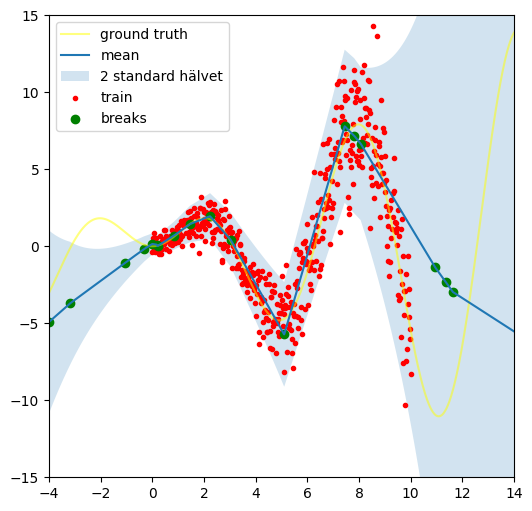

In [5]:
# 10-10 reluga on parema tulemuse saamiseks mõistlik kasutada 0.005 learning rate'i ja 4000 epochit
# aga 0.01 ja 2000 on ka ok

utils.reset_seeds(2002)

model = keras.Sequential([
    layers.Input(shape=(1,)),
    layers.Dense(units=10, activation='relu', name="layer_1"),
    layers.Dense(units=10, activation='relu', name="layer_2"),
    layers.Dense(units=2, activation='linear', name="layer_3")
])

X = np.linspace(0, 10, 500)
y = X * np.sin(X) + 0.3 * np.random.randn(500) + 0.3 * X * np.random.randn(500)

X_truth = np.linspace(-4, 14, 2000)
ground_truth = X_truth * np.sin(X_truth)

X_train, y_train = X, y
# X_valid, y_valid = np.linspace(-1.2, 1.2,10000), np.linspace(-1.2, 1.2, 10000)**2

model.compile(
    optimizer=keras.optimizers.Adam(
        learning_rate=0.005, amsgrad=True),
    loss=utils.neg_log_likelihood,
    # metrics=[keras.metrics.MeanSquaredError()],
)

h = model.fit(X_train, y_train, batch_size=64, epochs=4000, verbose=0,
              callbacks=[CustomLogger(100)], shuffle=True)

joonista_variance(model, X_truth, X_train, y_train, xlim=(-4, 14),
                  ylim=(-15, 15), ground_truth=lambda x: x*np.sin(x))


In [185]:
# jooniselt nr 1
tegelik_myra = lambda x: np.sqrt(0.09*x**2+0.09)

In [38]:
def rmse_from_model_variance_estimate(model, start, end, n_points=1000):
    """Joon nr2, mudeli poolt ennustatud variansi summast arvutatud RMSE,
    täpsemalt variancide keskmise ruutjuur

    :param model: _description_
    :param start: _description_
    :param end: _description_
    :param n_points: _description_, defaults to 1000
    :return: _description_
    """    
    X = np.linspace(start, end, n_points)
    y_pred = model.predict(X, verbose=0)
    y_pred_variance = np.exp(y_pred[:,1:])
    #assert abs(np.sum(y_pred_variance)/n_points - np.mean(y_pred_variance)) < 1e-5	
    return np.sqrt(np.sum(y_pred_variance)/n_points)

In [18]:
def rmse_from_modelmean_2_samples(model, X_test, y_test):
    """Joon nr3, mudeli poolt ennustatud keskväärtuse ja punktide vaheline kaugus

    :param model: _description_
    :param X_test: _description_
    :param y_test: _description_
    :return: _description_
    """    
    y_pred = model.predict(X_test, verbose=0)
    y_pred_mean = y_pred[:, 0]

    return np.sqrt(np.mean(
        (y_pred_mean-y_test)**2
    ))


In [19]:
def rmse_from_diff_means(model, start, end, fn, n_points=1000,):
    """Joon nr4, mudeli poolt ennustatud variansi summast arvutatud RMSE

    :param model: _description_
    :param start: _description_
    :param end: _description_
    :param n_points: _description_, defaults to 1000
    :return: _description_
    """    
    X = np.linspace(start, end, n_points)
    y_pred = model.predict(X, verbose=0)
    y_pred_mean = y_pred[:,0]
    y_true_mean = fn(X)
    return np.sqrt(np.mean(
                (y_true_mean-y_pred_mean)**2
            ))

In [12]:
def rmse_from_gtruth_2_samples(X_test, y_test, fn):
    """Joon nr5, testandmepunktide kaugus tõelisest funktsioonist

    :param X_test: testhulk
    :param y_test: testhulgale vastavate X-idele varem genetud y väärtused, et müra oleks kõikides katsetes sama
    :param fn: funktsioon mida ennustame
    :return: rmse v5
    """    
    y_true_mean = fn(X_test)
    return np.sqrt(np.mean(
        (y_true_mean-y_test)**2
    ))

In [47]:
a = np.linspace(5, 20, 6)
b = a**2
a2 = a[(a>=6)&(a<17)]
b2 = b[(a>=6)&(a<17)]
print(a2)
print(b2)

[ 8. 11. 14.]
[ 64. 121. 196.]


In [13]:
X_test = np.linspace(-2, 12, 10000)
y_test = X_test * np.sin(X_test) + 0.3 * X_test * np.random.randn(10000) + 0.3 * np.random.randn(10000)

In [ ]:
uuringuruum, step = np.linspace(0, 10, 100, retstep=True)


In [87]:
utils.reset_seeds(100)
X_test = np.linspace(-2, 12, 10000)
y_test = X_test * np.sin(X_test) + 0.3 * X_test * np.random.randn(10000) + 0.3 * np.random.randn(10000)


uuringuruum, step = np.linspace(0, 10, 100, retstep=True)
rmses = []
akna_laius = 0.2
assert akna_laius > step, "Soovitatav oleks akna laius suurem teha kui uuringuruumi samm"
for w_start in uuringuruum:
    w_end = w_start + akna_laius

    X_aknas = X_test[(X_test >= w_start) & (X_test < w_end)]
    y_aknas = y_test[(X_test >= w_start) & (X_test < w_end)]

    rmse1 = tegelik_myra((w_start+w_end)/2)
    rmse2 = rmse_from_model_variance_estimate(model, w_start, w_end)
    rmse3 = rmse_from_modelmean_2_samples(model, X_aknas, y_aknas)
    rmse4 = rmse_from_diff_means(model, w_start, w_end, lambda x: x*np.sin(x))
    rmse5 = rmse_from_gtruth_2_samples(X_aknas, y_aknas, lambda x: x*np.sin(x))
    rmses.extend([w_start, rmse1, rmse2, rmse3, rmse4, rmse5])
rmses = np.array(rmses).reshape(-1, 6)


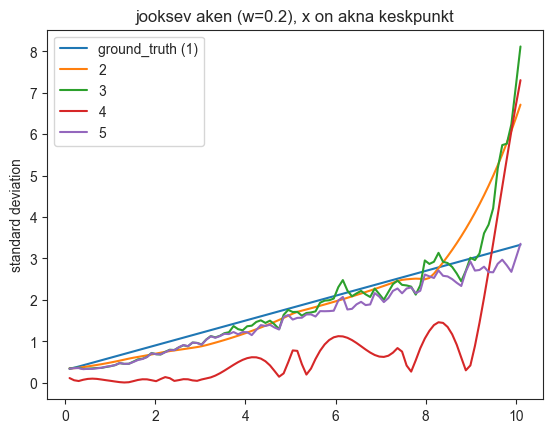

In [88]:
# Uus ja parem

# def fn(x): return 2*np.cos(x)+x


# bpoints = np.asanyarray(Slopes.breakpoint_finder(
#     model, np.linspace(-2.5, 12.5, 10000)))
# x_coord = [x[0] for x in bpoints[:, 0]]

sns.set_style('ticks')

fig, ax = plt.subplots()
# ax.hist(x_coord, alpha=0.5, label='breakpoints', bins=20)
# ax.set_ylabel('breakpoints',)

sns.lineplot(x=rmses[:, 0]+akna_laius/2, y=rmses[:, 1], label='ground_truth (1)')
sns.lineplot(x=rmses[:, 0]+akna_laius/2, y=rmses[:, 2], label='2')
sns.lineplot(x=rmses[:, 0]+akna_laius/2, y=rmses[:, 3], label='3')
sns.lineplot(x=rmses[:, 0]+akna_laius/2, y=rmses[:, 4], label='4')
sns.lineplot(x=rmses[:, 0]+akna_laius/2, y=rmses[:, 5], label='5')
ax.legend()
ax.set_ylabel('standard deviation')

# sns.kdeplot(x_coord, bw_method=0.4, color='red',
#             alpha=0.5, label='breakpoints', ax=ax.twinx())

# ax_ground_truth = ax.twinx()
# ax_ground_truth.set(yticklabels=[])
# sns.lineplot(x=rmses[:, 0]+akna_laius/2, y=fn(rmses[:, 0]+akna_laius/2),
#              alpha=0.2, label='func ise', ax=ax_ground_truth, color='purple')

plt.title(f"jooksev aken (w={akna_laius}), x on akna keskpunkt")
plt.show()

In [148]:
utils.reset_seeds(100)
fn = lambda x: x*np.sin(x)
X_test = np.linspace(-2, 12, 10000)
y_test = X_test * np.sin(X_test) + 0.3 * X_test * np.random.randn(10000) + 0.3 * np.random.randn(10000)

y_pred = model.predict(X_test, verbose=0)
y_pred_mean = y_pred[:, 0]
y_pred_variance = np.exp(y_pred[:,1:])
y_pred_sd = np.sqrt(y_pred_variance)

y_true_mean = fn(X_test)

uuringuruum, akna_laius = np.linspace(0, 10, 1000, retstep=True)
akna_laius = 0.1

rmses2 = []
for w_start in uuringuruum:
    
    w_end = w_start + akna_laius
    X_aknas = X_test[(X_test >= w_start) & (X_test < w_end)]
    y_aknas = y_test[(X_test >= w_start) & (X_test < w_end)]
    
    
    y_pred_aknas = y_pred[(X_test >= w_start) & (X_test < w_end)]
    y_pred_mean_aknas = y_pred_mean[(X_test >= w_start) & (X_test < w_end)]
    y_pred_variance_aknas = y_pred_variance[(X_test >= w_start) & (X_test < w_end)]
    y_pred_sd_aknas = y_pred_sd[(X_test >= w_start) & (X_test < w_end)]

    y_true_mean_aknas = y_true_mean[(X_test >= w_start) & (X_test < w_end)]

    rmse1 = tegelik_myra((w_start+w_end)/2)
    rmse2 = np.sqrt(np.mean(y_pred_variance_aknas))
    rmse3 =  np.sqrt(np.mean(
        (y_pred_mean_aknas-y_aknas)**2
    ))
    rmse4 =  np.sqrt(np.mean(
        (y_true_mean_aknas-y_pred_mean_aknas)**2
    ))
    rmse5 =  np.sqrt(np.mean(
        (y_true_mean_aknas-y_aknas)**2
    ))
    rmses2.append([w_start, rmse1, rmse2, rmse3, rmse4, rmse5])
    #print(f"{w_start:.2f} {rmse1:.2f} {rmse2:.2f} {rmse3:.2f} {rmse4:.2f} {rmse5:.2f}")

rmses2 = np.array(rmses2).reshape(-1, 6)

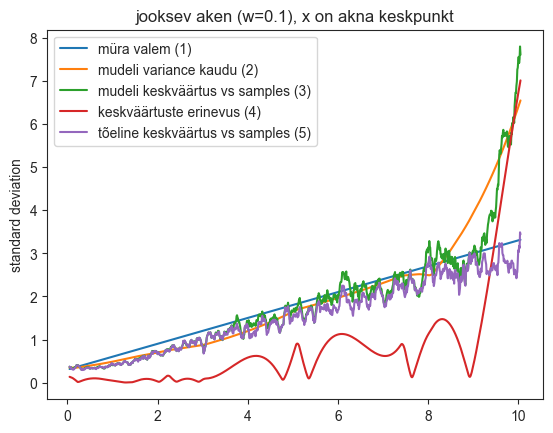

In [164]:
# Uus ja parem

sns.set_style('ticks')

fig, ax = plt.subplots()


sns.lineplot(x=rmses2[:, 0]+akna_laius/2, y=rmses2[:, 1], label='müra valem (1)')
sns.lineplot(x=rmses2[:, 0]+akna_laius/2, y=rmses2[:, 2], label='mudeli variance kaudu (2)') # mudel annab välja log-variance. Ehk tegelikult tuleks võtta hoopis selle ruutjuur - ei ole, see on juba sd sest me võtsime ruutjuure enne
sns.lineplot(x=rmses2[:, 0]+akna_laius/2, y=rmses2[:, 3], label='mudeli keskväärtus vs samples (3)')
sns.lineplot(x=rmses2[:, 0]+akna_laius/2, y=rmses2[:, 4], label='keskväärtuste erinevus (4)')
sns.lineplot(x=rmses2[:, 0]+akna_laius/2, y=rmses2[:, 5], label='tõeline keskväärtus vs samples (5)')
ax.legend()
ax.set_ylabel('standard deviation')
#ax.set_xlim(0,4)

plt.title(f"jooksev aken (w={akna_laius}), x on akna keskpunkt")
plt.show()

### Hüpotees: 2 on alati suurem kui 1

<AxesSubplot: >

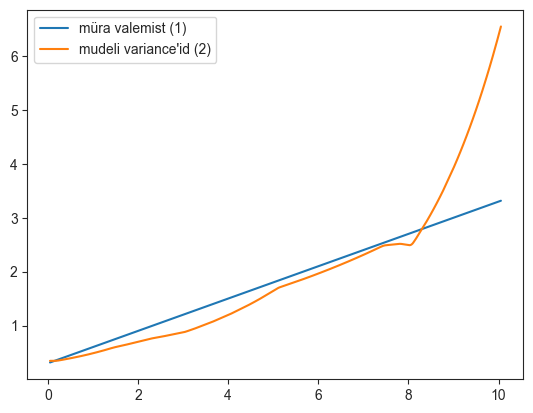

In [165]:
sns.lineplot(x=rmses2[:, 0]+akna_laius/2, y=rmses2[:, 1], label='müra valemist (1)')
sns.lineplot(x=rmses2[:, 0]+akna_laius/2, y=rmses2[:, 2], label='mudeli variance\'id (2)')

### Hüpotees: 1.+4.=3.

<AxesSubplot: >

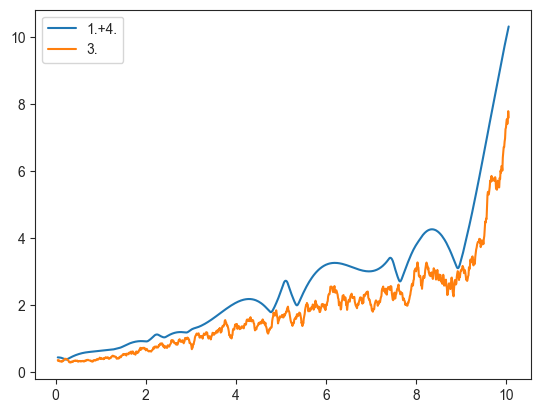

In [162]:
sns.lineplot(x=rmses2[:, 0]+akna_laius/2, y=np.clip(rmses2[:, 1]+rmses2[:, 4], a_min=None, a_max=15) , label='1.+4.')
sns.lineplot(x=rmses2[:, 0]+akna_laius/2, y=np.clip(rmses2[:, 3], a_min=None, a_max=15), label='3.')

<AxesSubplot: >

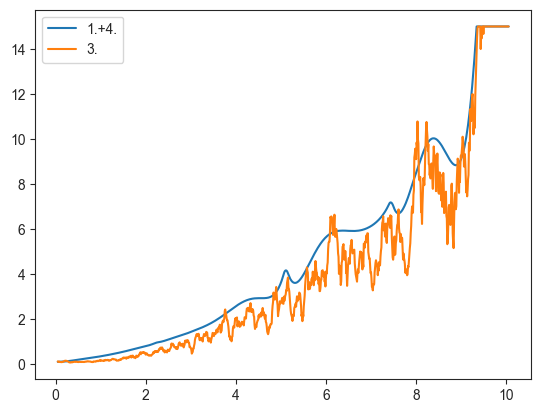

In [166]:
sns.lineplot(x=rmses2[:, 0]+akna_laius/2, y=np.clip(rmses2[:, 1]**2+rmses2[:, 4]**2, a_min=None, a_max=15) , label='1.+4.')
sns.lineplot(x=rmses2[:, 0]+akna_laius/2, y=np.clip(rmses2[:, 3]**2, a_min=None, a_max=15), label='3.')

## Vähem andmeid

Epoch:   0 | Loss: 3.61072e+00
Epoch: 100 | Loss: 3.16952e+00
Epoch: 200 | Loss: 3.11769e+00
Epoch: 300 | Loss: 3.08393e+00
Epoch: 400 | Loss: 3.04173e+00
Epoch: 500 | Loss: 2.98111e+00
Epoch: 600 | Loss: 2.91910e+00
Epoch: 700 | Loss: 2.84629e+00
Epoch: 800 | Loss: 2.72611e+00
Epoch: 900 | Loss: 2.58529e+00
Epoch: 1000 | Loss: 2.27614e+00
Epoch: 1100 | Loss: 2.08060e+00
Epoch: 1200 | Loss: 1.95895e+00
Epoch: 1300 | Loss: 1.88620e+00
Epoch: 1400 | Loss: 1.82137e+00
Epoch: 1500 | Loss: 1.70310e+00
Epoch: 1600 | Loss: 1.63628e+00
Epoch: 1700 | Loss: 1.59161e+00
Epoch: 1800 | Loss: 1.59791e+00
Epoch: 1900 | Loss: 1.57491e+00
Epoch: 2000 | Loss: 1.55656e+00
Epoch: 2100 | Loss: 1.60903e+00
Epoch: 2200 | Loss: 1.57057e+00
Epoch: 2300 | Loss: 1.55754e+00
Epoch: 2400 | Loss: 1.54610e+00
Epoch: 2500 | Loss: 1.53559e+00
Epoch: 2600 | Loss: 1.52580e+00
Epoch: 2700 | Loss: 1.52127e+00
Epoch: 2800 | Loss: 1.81025e+00
Epoch: 2900 | Loss: 1.55476e+00
Epoch: 3000 | Loss: 1.53067e+00
Epoch: 3100 | Loss

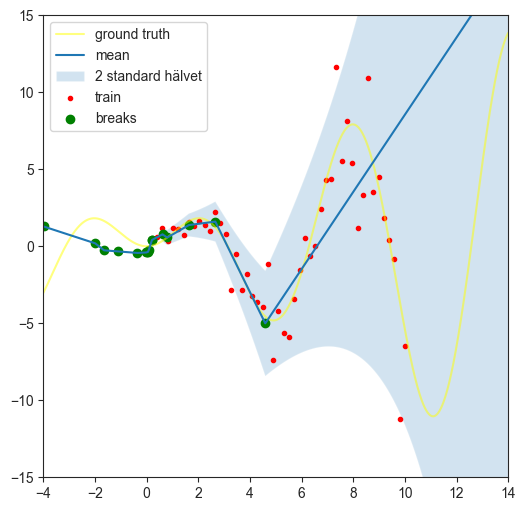

In [169]:
# 10-10 reluga on parema tulemuse saamiseks mõistlik kasutada 0.005 learning rate'i ja 4000 epochit
# aga 0.01 ja 2000 on ka ok

utils.reset_seeds(2002)

model = keras.Sequential([
    layers.Input(shape=(1,)),
    layers.Dense(units=10, activation='relu', name="layer_1"),
    layers.Dense(units=10, activation='relu', name="layer_2"),
    layers.Dense(units=2, activation='linear', name="layer_3")
])

X = np.linspace(0, 10, 50)
y = X * np.sin(X) + 0.3 * np.random.randn(50) + 0.3 * X * np.random.randn(50)

X_truth = np.linspace(-4, 14, 2000)
ground_truth = X_truth * np.sin(X_truth)

X_train, y_train = X, y
# X_valid, y_valid = np.linspace(-1.2, 1.2,10000), np.linspace(-1.2, 1.2, 10000)**2

model.compile(
    optimizer=keras.optimizers.Adam(
        learning_rate=0.003, amsgrad=True),
    loss=utils.neg_log_likelihood,
    # metrics=[keras.metrics.MeanSquaredError()],
)

h = model.fit(X_train, y_train, batch_size=64, epochs=4000, verbose=0,
              callbacks=[CustomLogger(100)], shuffle=True)

joonista_variance(model, X_truth, X_train, y_train, xlim=(-4, 14),
                  ylim=(-15, 15), ground_truth=lambda x: x*np.sin(x))


In [188]:
utils.reset_seeds(100)
fn = lambda x: x*np.sin(x)
X_test = np.linspace(-2, 12, 10000)
y_test = X_test * np.sin(X_test) + 0.3 * X_test * np.random.randn(10000) + 0.3 * np.random.randn(10000)

y_pred = model.predict(X_test, verbose=0)
y_pred_mean = y_pred[:, 0]
y_pred_variance = np.exp(y_pred[:,1:])
y_pred_sd = np.sqrt(y_pred_variance)

y_true_mean = fn(X_test)

uuringuruum, akna_laius = np.linspace(0, 10, 10000, retstep=True)
akna_laius = 0.1

rmses2 = []
for w_start in uuringuruum:
    
    w_end = w_start + akna_laius
    X_aknas = X_test[(X_test >= w_start) & (X_test < w_end)]
    y_aknas = y_test[(X_test >= w_start) & (X_test < w_end)]
    
    
    y_pred_aknas = y_pred[(X_test >= w_start) & (X_test < w_end)]
    y_pred_mean_aknas = y_pred_mean[(X_test >= w_start) & (X_test < w_end)]
    y_pred_variance_aknas = y_pred_variance[(X_test >= w_start) & (X_test < w_end)]
    y_pred_sd_aknas = y_pred_sd[(X_test >= w_start) & (X_test < w_end)]

    y_true_mean_aknas = y_true_mean[(X_test >= w_start) & (X_test < w_end)]

    rmse1 = tegelik_myra((w_start+w_end)/2)
    rmse2 = np.sqrt(np.mean(y_pred_variance_aknas))
    rmse3 =  np.sqrt(np.mean(
        (y_pred_mean_aknas-y_aknas)**2
    ))
    rmse4 =  np.sqrt(np.mean(
        (y_true_mean_aknas-y_pred_mean_aknas)**2
    ))
    rmse5 =  np.sqrt(np.mean(
        (y_true_mean_aknas-y_aknas)**2
    ))
    rmses2.append([w_start, rmse1, rmse2, rmse3, rmse4, rmse5])
    #print(f"{w_start:.2f} {rmse1:.2f} {rmse2:.2f} {rmse3:.2f} {rmse4:.2f} {rmse5:.2f}")

rmses2 = np.array(rmses2).reshape(-1, 6)

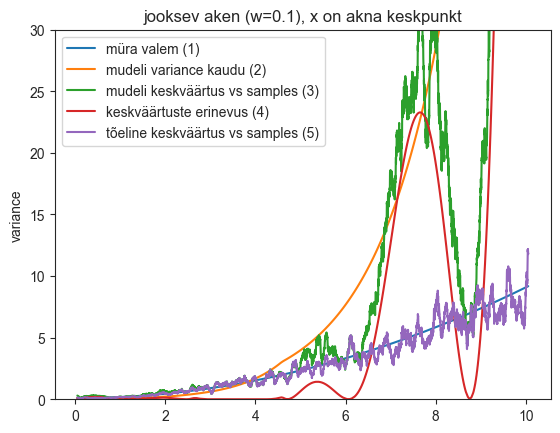

In [189]:
# Uus ja parem

sns.set_style('ticks')

fig, ax = plt.subplots()


sns.lineplot(x=rmses2[:, 0]+akna_laius/2, y=rmses2[:, 1]**2, label='müra valem (1)')
sns.lineplot(x=rmses2[:, 0]+akna_laius/2, y=rmses2[:, 2]**2, label='mudeli variance kaudu (2)') # mudel annab välja log-variance. Ehk tegelikult tuleks võtta hoopis selle ruutjuur - ei ole, see on juba sd sest me võtsime ruutjuure enne
sns.lineplot(x=rmses2[:, 0]+akna_laius/2, y=rmses2[:, 3]**2, label='mudeli keskväärtus vs samples (3)')
sns.lineplot(x=rmses2[:, 0]+akna_laius/2, y=rmses2[:, 4]**2, label='keskväärtuste erinevus (4)')
sns.lineplot(x=rmses2[:, 0]+akna_laius/2, y=rmses2[:, 5]**2, label='tõeline keskväärtus vs samples (5)')
ax.legend()
ax.set_ylabel('variance')

ax.set_ylim(0,30)

plt.title(f"jooksev aken (w={akna_laius}), x on akna keskpunkt")
plt.show()

<AxesSubplot: >

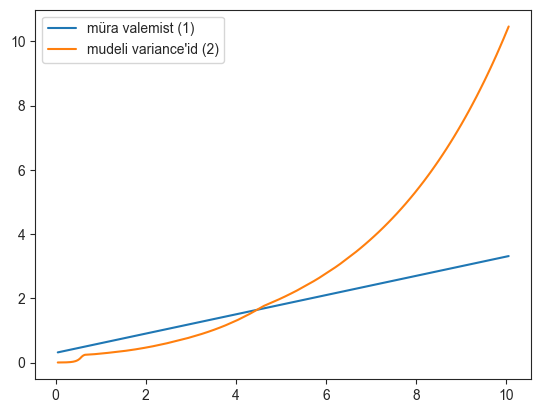

In [172]:
sns.lineplot(x=rmses2[:, 0]+akna_laius/2, y=rmses2[:, 1], label='müra valemist (1)')
sns.lineplot(x=rmses2[:, 0]+akna_laius/2, y=rmses2[:, 2], label='mudeli variance\'id (2)')

<AxesSubplot: >

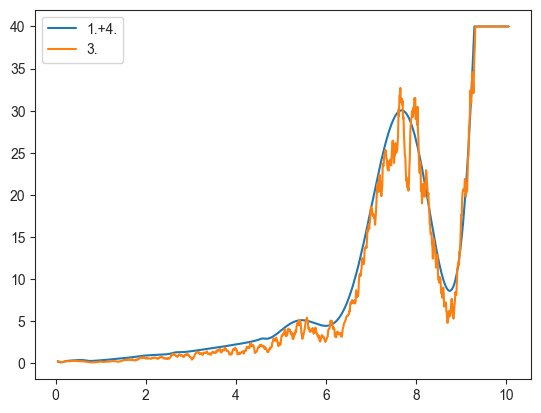

In [175]:
sns.lineplot(x=rmses2[:, 0]+akna_laius/2, y=np.clip(rmses2[:, 1]**2+rmses2[:, 4]**2, a_min=None, a_max=40) , label='1.+4.')
sns.lineplot(x=rmses2[:, 0]+akna_laius/2, y=np.clip(rmses2[:, 3]**2, a_min=None, a_max=40), label='3.')

In [ ]:
# Bias on E(f_hat) - E(y)

model contains 18 breaks
63/63 [==============================] - 0s 3ms/step


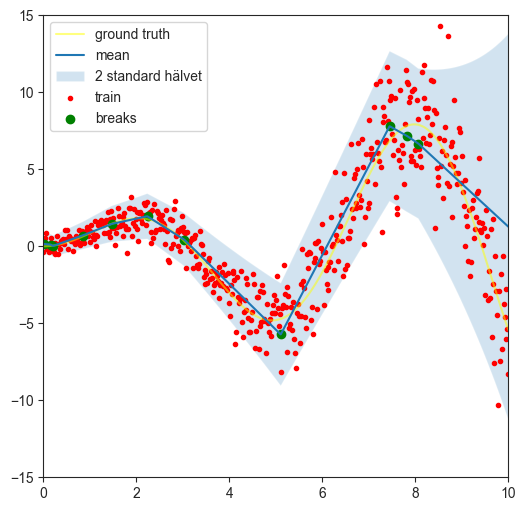

In [65]:
joonista_variance(model, X_truth, X_train, y_train, xlim=(0, 10),
                  ylim=(-15, 15), ground_truth=lambda x: x*np.sin(x))